# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train_data5 = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_train_data_5.csv", index_col=0)
test_data5 = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_test_data_5.csv", index_col=0)

In [ ]:
test_data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 5337 to 6083
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     747 non-null    float64
 1   air_end_temp   747 non-null    float64
 2   out_pressure   747 non-null    float64
 3   motor_current  747 non-null    float64
 4   motor_rpm      747 non-null    float64
 5   motor_temp     747 non-null    float64
 6   motor_vibe     747 non-null    float64
 7   type           747 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 52.5 KB


# 데이터 전처리

### 데이터 증강

In [ ]:
from sklearn.cluster import KMeans

def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=7):
    # Feature 선택
    X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]

    # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
    kmeans = KMeans(n_clusters=n_clusters, n_init=10000, random_state=42).fit(X)

    # 클러스터링 결과 중심점을 centroids에 저장합니다.
    centroids = kmeans.cluster_centers_

    # 각 클러스터의 개수를 저장합니다.
    cluster_sizes = np.bincount(kmeans.labels_)

    # 새로운 데이터를 저장할 빈 리스트를 생성합니다.
    new_data = []

    # 각 클러스터의 중심점을 이용하여 새로운 데이터를 생성합니다.
    for i, centroid in enumerate(centroids):
        for j in range(int(num_new_data * cluster_sizes[i] / len(X))):
            # 중심점 주변에 임의의 값으로 노이즈를 추가합니다.
            new_point = centroid + np.random.normal(scale=0.1, size=len(centroid))
            new_data.append(new_point)

    # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
    new_data = pd.DataFrame(new_data, columns=X.columns)

    # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
    final_data = pd.concat([train_data, new_data], ignore_index=True)

    return final_data

In [ ]:
new_train_data5 = cluster_based_augmentation(train_data5)
new_train_data5['type'] = 5
new_train_data5['out_pressure'] = 0.7

### type -> hp(Horse Power)
    * type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

new_train_data5['hp'] = new_train_data5['type'].map(mapping_dict)
test_data5['hp'] = test_data5['type'].map(mapping_dict)

In [ ]:
new_train_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     10244 non-null  float64
 1   air_end_temp   10244 non-null  float64
 2   out_pressure   10244 non-null  float64
 3   motor_current  10244 non-null  float64
 4   motor_rpm      10244 non-null  float64
 5   motor_temp     10244 non-null  float64
 6   motor_vibe     10244 non-null  float64
 7   type           10244 non-null  int64  
 8   hp             10244 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 720.4 KB


### 새로운 Feature 추가하기

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
new_train_data5['air_inflow_per_motor_current'] = new_train_data5['air_inflow'] / new_train_data5['motor_current']	
test_data5['air_inflow_per_motor_current'] = test_data5['air_inflow'] / test_data5['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
new_train_data5['Compressor_Efficiency1'] = new_train_data5['out_pressure'] * new_train_data5['air_inflow'] / new_train_data5['motor_current'] / 3.5168 / new_train_data5['hp']
test_data5['Compressor_Efficiency1'] = test_data5['out_pressure'] * test_data5['air_inflow'] / test_data5['motor_current'] / 3.5168 / test_data5['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
new_train_data5['Motor_Efficiency'] = (new_train_data5['motor_current'] * new_train_data5['motor_rpm'] * new_train_data5['hp']) / (746 * 1000)
test_data5['Motor_Efficiency'] = (test_data5['motor_current'] * test_data5['motor_rpm'] * test_data5['hp']) / (746 * 1000)

# 압축기의 효율2
new_train_data5['Compressor_Efficiency2'] = (new_train_data5['out_pressure'] * new_train_data5['air_inflow'] * (new_train_data5['air_end_temp'] - 25)) / (new_train_data5['motor_current'] * new_train_data5['motor_vibe'] * new_train_data5['hp'] * 3.6)
test_data5['Compressor_Efficiency2'] = (test_data5['out_pressure'] * test_data5['air_inflow'] * (test_data5['air_end_temp'] - 25)) / (test_data5['motor_current'] * test_data5['motor_vibe'] * test_data5['hp'] * 3.6)

# 압축기의 배출량
new_train_data5['Discharge_Volume'] = (new_train_data5['air_inflow'] / 60) * ((new_train_data5['air_end_temp'] + 273) / 273) * (new_train_data5['out_pressure'] / 1.01325)
test_data5['Discharge_Volume'] = (test_data5['air_inflow'] / 60) * ((test_data5['air_end_temp'] + 273) / 273) * (test_data5['out_pressure'] / 1.01325)

# 공기의 밀도
new_train_data5['air_density'] = new_train_data5['out_pressure'] / (287 * (new_train_data5['air_end_temp'] + 273))
test_data5['air_density'] = test_data5['out_pressure'] / (287 * (test_data5['air_end_temp'] + 273))

# 모델링

### PyTorch 모델링

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

In [ ]:
# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, hidden_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, encoding_dim)
#         self.fc2 = nn.Linear(encoding_dim, hidden_dim)
#         self.activation = nn.ReLU()

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         return x


# class Decoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, hidden_dim):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(hidden_dim, encoding_dim)
#         self.fc2 = nn.Linear(encoding_dim, input_dim)
#         self.activation = nn.ReLU()

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.fc2(x)
#         return x


# class AutoEncoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim, hidden_dim):
#         super(AutoEncoder, self).__init__()
#         self.encoder = Encoder(input_dim, encoding_dim, hidden_dim)
#         self.decoder = Decoder(input_dim, encoding_dim, hidden_dim)

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(new_train_data5)
test_data_scaled = scaler.transform(test_data5)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [ ]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

# model = AutoEncoder(input_dim, encoding_dim, hidden_dim)
model = Autoencoder()
# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=15, bias=True)
  )
)


In [ ]:
model_name = 'type5_kmeans10000'

In [ ]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.008478420315079801, val loss: 0.016016434878110886
Epoch 2, train loss: 0.007119556436186445, val loss: 0.01081150770187378
Epoch 3, train loss: 0.0058660138036934996, val loss: 0.0076162125915288925
Epoch 4, train loss: 0.0034476033809123148, val loss: 0.0060479543171823025
Epoch 5, train loss: 0.0017367310569087412, val loss: 0.0061024208553135395
Epoch 6, train loss: 0.0012520766272549604, val loss: 0.005322394892573357
Epoch 7, train loss: 0.0011171226855685621, val loss: 0.004600455518811941
Epoch 8, train loss: 0.0009935178875516589, val loss: 0.003934819716960192
Epoch 9, train loss: 0.0009132346963129533, val loss: 0.002666652901098132
Epoch 10, train loss: 0.0007550571805361858, val loss: 0.0021756647620350122
Epoch 11, train loss: 0.0005910876104093606, val loss: 0.001676775747910142
Epoch 12, train loss: 0.0004737001156736433, val loss: 0.0014785024104639888
Epoch 13, train loss: 0.0004048974555798896, val loss: 0.0011422262759879231
Epoch 14, train lo

In [ ]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)
test_data_reconstructed

tensor([[ 1.3090e+00,  1.3326e+00,  3.3519e-03,  ...,  1.1851e+00,
          1.3140e+00, -1.3129e+00],
        [-7.0257e-01, -7.1088e-01, -1.1124e-02,  ..., -6.3136e-01,
         -7.0374e-01,  7.1606e-01],
        [ 8.6735e-02,  6.9602e-02, -1.0915e-03,  ...,  2.0493e-01,
          5.5979e-02, -1.0021e-01],
        ...,
        [ 5.1444e-01,  1.1544e+00,  1.9406e-02,  ...,  1.8785e-01,
          5.4611e-01, -1.1285e+00],
        [ 9.0251e-01,  1.5640e+00,  2.8249e-02,  ...,  4.7499e-01,
          9.4283e-01, -1.5165e+00],
        [ 1.0052e-01,  6.9728e-01,  1.1509e-02,  ..., -1.3378e-01,
          1.3083e-01, -6.8703e-01]], grad_fn=<AddmmBackward0>)

In [ ]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)
reconstruction_error

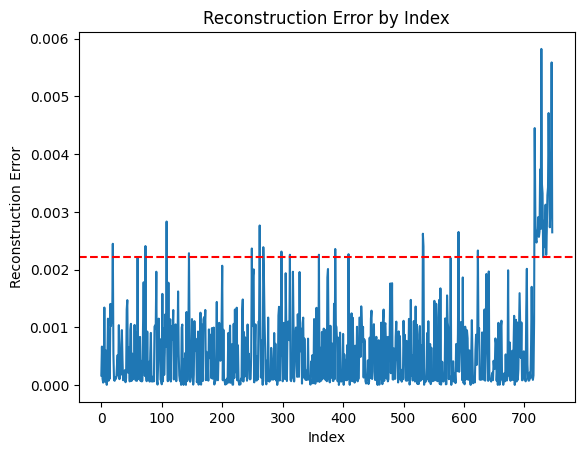

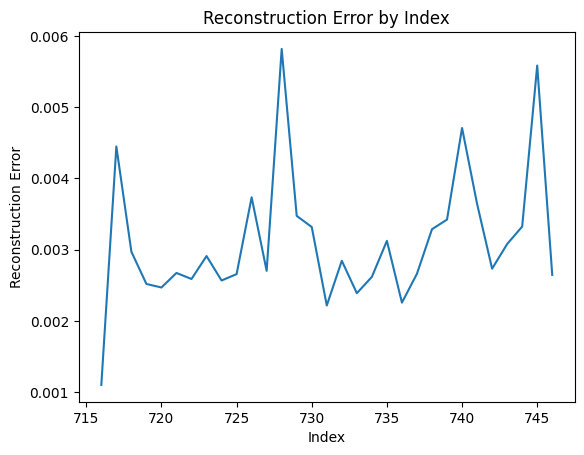

In [ ]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
plt.axhline(y=0.002224856168031693, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()


# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 716
end_index = 747
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
# plt.axhline(y=0.004, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

In [ ]:
start_idx = 270
end_idx = 1100
reconstruction_error_mean = torch.max(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_mean)
x

0.0033576549030840397

In [ ]:
start_idx = 717
end_idx = 747
reconstruction_error_mean = torch.min(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_mean)
x

0.002215201500803232

In [ ]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 93.967)
threshold

0.002215131127405912

In [ ]:
# Predict anomalies in test_data
test_prediction5 = (reconstruction_error.detach().numpy() > threshold).astype(int)

# 데이터 저장

In [ ]:
from collections import Counter

count = Counter(test_prediction5)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  701
Number of 1s:  46


In [ ]:
file_name = model_name + '_th93967'

In [ ]:
# 코랩에 저장
idx = test_data5.loc[:, 'type']
y_pred = {'type': idx, 'label': test_prediction5}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")